# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](unet.PNG)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [1]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [2]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

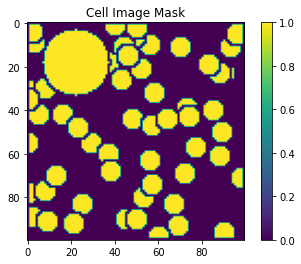

Class Weighting: {0: 0, 1: 0}


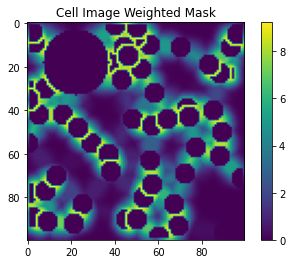

In [3]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: 0, # background
  1: 0  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

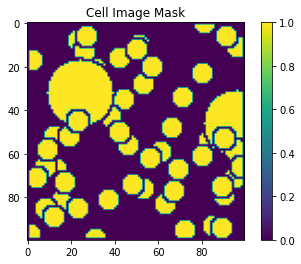

Class Weighting: {0: 0.3, 1: 0.7}


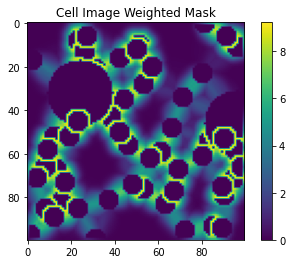

In [4]:
# different class weights
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: .3, # background
  1: .7  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

**TO DO: Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.**


# Implementing U-Net

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [6]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [7]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**

Because of the padding, the output should be the same size as the input


In [8]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [9]:
from PIL import Image
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions
Some of the operations we perform can be functionalized to save on repetition. The two examples below are getting the data loaders and validating the model.

In [10]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def validation_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(f"Got {num_correct}/{num_pixels} pixels with acc {num_correct/num_pixels*100:.2f}")
    model.train()

### Training Function

In [11]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx+1}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [12]:
# Hyperparameters

# TODO: experiment with different values
LEARNING_RATE = 1e-4
BATCH_SIZE = 1

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd()

TRAIN_IMG_DIR = os.path.join(cwd, "data", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

**Question: Why do we use the BCEWithLogitsLoss function for training the model?**  
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

This function combines a Sigmoid layer and BCELosss which is more numerically stable and works well when your target outputs are 0 and 1 (for no car vs car in our case). This lets us get a per pixel prediction from the sigmoid layer and compute the loss of said prediction in a single step.


**Question: Given the authors of the original U-Net paper chose SGD, is Adam the best optimizer for this implementation?**  
Consider trying [a couple of different ones](https://pytorch.org/docs/stable/optim.html#algorithms) and see what happens.

Adam is better here - we get better validation accuracy and by looking at the prediction masks is looks like SGD has a harder time distinguishing between background and car

In [14]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 1/224, Loss: 0.7018
Iter: 2/224, Loss: 0.6768
Iter: 3/224, Loss: 0.5861
Iter: 4/224, Loss: 0.6239
Iter: 5/224, Loss: 0.6155
Iter: 6/224, Loss: 0.4770
Iter: 7/224, Loss: 0.5464
Iter: 8/224, Loss: 0.5237
Iter: 9/224, Loss: 0.5561
Iter: 10/224, Loss: 0.4155
Iter: 11/224, Loss: 0.4063
Iter: 12/224, Loss: 0.4217
Iter: 13/224, Loss: 0.3800
Iter: 14/224, Loss: 0.4489
Iter: 15/224, Loss: 0.4211
Iter: 16/224, Loss: 0.3570
Iter: 17/224, Loss: 0.3806
Iter: 18/224, Loss: 0.3880
Iter: 19/224, Loss: 0.3463
Iter: 20/224, Loss: 0.3258
Iter: 21/224, Loss: 0.3601
Iter: 22/224, Loss: 0.3051
Iter: 23/224, Loss: 0.3483
Iter: 24/224, Loss: 0.3349
Iter: 25/224, Loss: 0.2870
Iter: 26/224, Loss: 0.2969
Iter: 27/224, Loss: 0.2696
Iter: 28/224, Loss: 0.3303
Iter: 29/224, Loss: 0.3466
Iter: 30/224, Loss: 0.2994
Iter: 31/224, Loss: 0.3056
Iter: 32/224, Loss: 0.2972
Iter: 33/224, Loss: 0.3139
Iter: 34/224, Loss: 0.2828
Iter: 35/224, Loss: 0.2702
Iter: 36/224, Loss: 0.2538
Iter: 37/224, Loss: 0.2693
Iter: 38/2

In [15]:
sgd_model = UNET(in_channels=3, out_channels=1)

sgd_loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
sgd_optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

sgd_train_loader, sgd_val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(sgd_train_loader, sgd_model, sgd_optimizer, sgd_loss_fn)

Iter: 1/224, Loss: 0.6489
Iter: 2/224, Loss: 0.6609
Iter: 3/224, Loss: 0.6453
Iter: 4/224, Loss: 0.6609
Iter: 5/224, Loss: 0.6480
Iter: 6/224, Loss: 0.6531
Iter: 7/224, Loss: 0.6421
Iter: 8/224, Loss: 0.6562
Iter: 9/224, Loss: 0.6500
Iter: 10/224, Loss: 0.6420
Iter: 11/224, Loss: 0.6624
Iter: 12/224, Loss: 0.6602
Iter: 13/224, Loss: 0.6512
Iter: 14/224, Loss: 0.6510
Iter: 15/224, Loss: 0.6481
Iter: 16/224, Loss: 0.6514
Iter: 17/224, Loss: 0.6514
Iter: 18/224, Loss: 0.6646
Iter: 19/224, Loss: 0.6486
Iter: 20/224, Loss: 0.6535
Iter: 21/224, Loss: 0.6471
Iter: 22/224, Loss: 0.6653
Iter: 23/224, Loss: 0.6534
Iter: 24/224, Loss: 0.6449
Iter: 25/224, Loss: 0.6462
Iter: 26/224, Loss: 0.6487
Iter: 27/224, Loss: 0.6564
Iter: 28/224, Loss: 0.6468
Iter: 29/224, Loss: 0.6509
Iter: 30/224, Loss: 0.6641
Iter: 31/224, Loss: 0.6685
Iter: 32/224, Loss: 0.6455
Iter: 33/224, Loss: 0.6513
Iter: 34/224, Loss: 0.6515
Iter: 35/224, Loss: 0.6508
Iter: 36/224, Loss: 0.6479
Iter: 37/224, Loss: 0.6437
Iter: 38/2

### Validating the Model

In [16]:
validation_accuracy(val_loader, model)
validation_accuracy(sgd_val_loader, sgd_model)

Got 2350428/2457600 pixels with acc 95.64
Got 1531400/2457600 pixels with acc 62.31


Let's visualise a couple randomly selected validation predictions and see how well the model did.

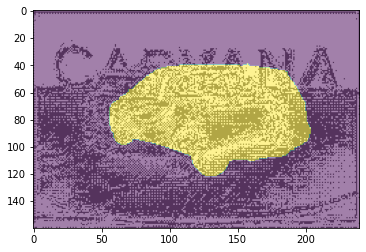

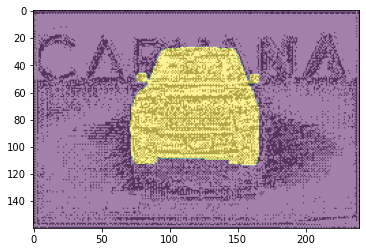

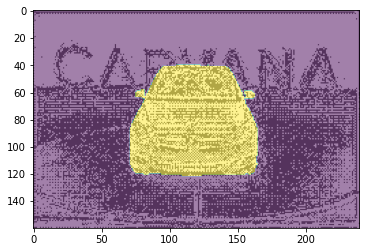

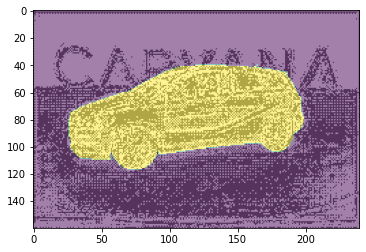

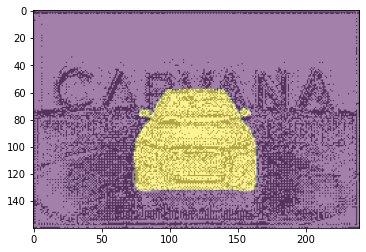

In [21]:
# SGD model predictions
num_predictions = 5

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(sgd_val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(sgd_model(sgd_val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()

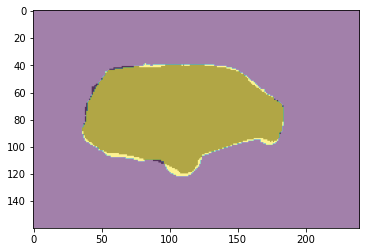

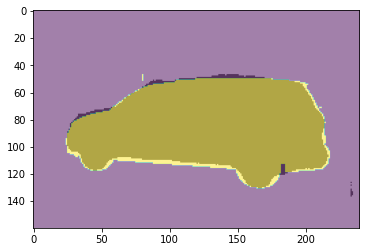

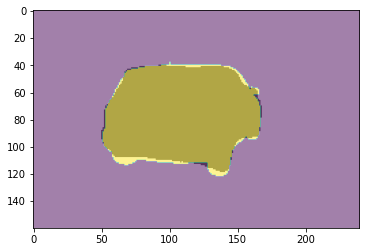

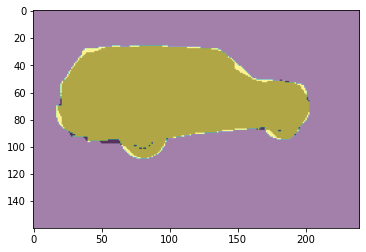

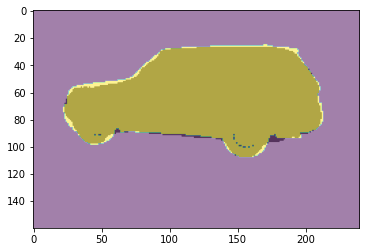

In [17]:
# TODO: how many predictions do you want to visualize?
# Adam model predictions
num_predictions = 5

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

**Question: What you do notice about the predicted mask that is less than optimal?**  

The mask doesn't work as optimally when the car is shown at an angle (slight discrepency between the prediction and where the car actually is) but it doesn't look that bad

### Data Augmentation
Let's train the model on some new data (in a sense). We can augment the data that we feed to the model by performing horizontal flips on the images of the cars, or even changing the distribution of the normalized values. 

In [18]:
train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)


Now continue training the model:

In [19]:
train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.1692
Iter: 2/224, Loss: 0.1585
Iter: 3/224, Loss: 0.1557
Iter: 4/224, Loss: 0.1664
Iter: 5/224, Loss: 0.1528
Iter: 6/224, Loss: 0.1562
Iter: 7/224, Loss: 0.1615
Iter: 8/224, Loss: 0.1591
Iter: 9/224, Loss: 0.1707
Iter: 10/224, Loss: 0.1649
Iter: 11/224, Loss: 0.1493
Iter: 12/224, Loss: 0.1647
Iter: 13/224, Loss: 0.1511
Iter: 14/224, Loss: 0.1520
Iter: 15/224, Loss: 0.1489
Iter: 16/224, Loss: 0.1801
Iter: 17/224, Loss: 0.1761
Iter: 18/224, Loss: 0.1567
Iter: 19/224, Loss: 0.1786
Iter: 20/224, Loss: 0.1480
Iter: 21/224, Loss: 0.1461
Iter: 22/224, Loss: 0.1891
Iter: 23/224, Loss: 0.1745
Iter: 24/224, Loss: 0.1515
Iter: 25/224, Loss: 0.1922
Iter: 26/224, Loss: 0.1510
Iter: 27/224, Loss: 0.1501
Iter: 28/224, Loss: 0.1460
Iter: 29/224, Loss: 0.1600
Iter: 30/224, Loss: 0.1526
Iter: 31/224, Loss: 0.1590
Iter: 32/224, Loss: 0.1409
Iter: 33/224, Loss: 0.1424
Iter: 34/224, Loss: 0.1678
Iter: 35/224, Loss: 0.1475
Iter: 36/224, Loss: 0.1555
Iter: 37/224, Loss: 0.1353
Iter: 38/2

Take a look at some of the model predictions.  
  
**Question: How has the model performance changed and why?** 

I assumed the model would do better with the augmented data since it would be exposed to more orientations but it gave nearly the same accuracy as before. The mask prediction is often flipped which is interesting, this is most likely due to the new orientations of data the model recieves. Maybe this is a case where data augmentation with U-Net does not make sense given the context whereas it does make sense to augment biological type data as we say from the paper.

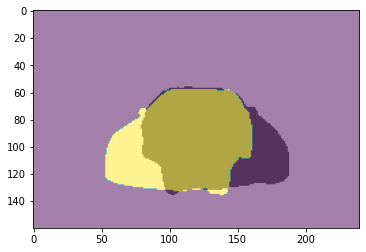

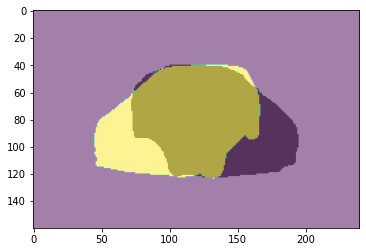

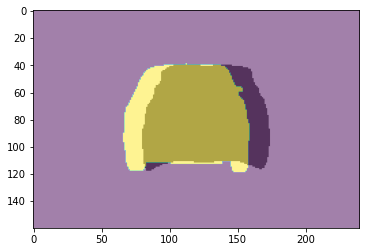

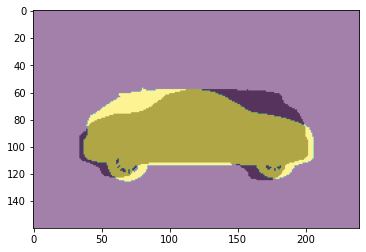

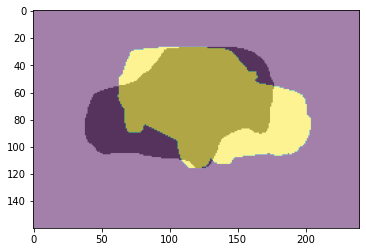

In [20]:
# TODO: how many predictions do you want to visualize?
num_predictions = 5

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()


In [22]:
validation_accuracy(val_loader, model)

Got 2328440/2457600 pixels with acc 94.74


**As an optional final task, try training a new model on variations of augmented data and see how the performance changes with different augmentations.** 